# Import packages

In [1]:
import pandas as pd
import numpy as np
import pickle

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# cross validation
from sklearn.model_selection import KFold

# optimization
from skopt import BayesSearchCV

# metrics
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, \
                        roc_auc_score, classification_report, confusion_matrix,\
                            ConfusionMatrixDisplay

# model training function
from modeling_functions.train_model_funcs import train_funcs

# Setup

In [2]:
# Random state
seed = 18

# modeling metrics storage
model_acc = dict()

## Helper Functions

In [3]:
def calc_mean(array):
    return np.mean(array)

In [4]:
def train_model(model, cv, model_name, x_train, y_train):
    train_scores = dict()
    val_scores = dict()

    train_acc_scores = list()
    train_roc_scores = list()
    train_mcc_scores = list()
    train_f1_scores = list()

    acc_scores = list()
    roc_scores = list()
    mcc_scores = list()
    f1_scores = list()
    
    n = 1

    # cross validation
    for train, test in cv.split(x_train, y_train):
        model.fit(x_train[train], y_train[train])

        # predict on validation set
        train_preds = model.predict(x_train[train])
        preds = model.predict(x_train[test])

        # store metrics
        train_acc = accuracy_score(train_preds, y_train[train])
        train_acc_scores.append(train_acc)
        val_acc = accuracy_score(preds, y_train[test])
        acc_scores.append(val_acc)

        train_f1 = f1_score(train_preds, y_train[train])
        train_f1_scores.append(train_f1)
        val_f1 = f1_score(preds, y_train[test])
        f1_scores.append(val_f1)

        train_roc = roc_auc_score(train_preds, y_train[train])
        train_roc_scores.append(train_roc)
        val_roc = roc_auc_score(preds, y_train[test])
        roc_scores.append(val_roc)

        train_mcc = matthews_corrcoef(train_preds, y_train[train])
        train_mcc_scores.append(train_mcc)
        mcc = matthews_corrcoef(preds, y_train[test])
        mcc_scores.append(mcc)

        print(f"train accuracy split {n}: {train_acc}")
        print(f"validation accuracy split {n}: {val_acc}")

        n += 1

    # metrics
    train_scores[model_name] = {
        'acc': calc_mean(train_acc_scores),
        'roc': calc_mean(train_roc_scores),
        'f1': calc_mean(train_f1_scores),
        'mcc': calc_mean(train_mcc_scores)
    }

    val_scores[model_name] = {
        'acc': calc_mean(acc_scores),
        'roc': calc_mean(roc_scores),
        'f1': calc_mean(f1_scores),
        'mcc': calc_mean(mcc_scores)
    }
    
    
    return train_scores, val_scores

## Load Data

In [5]:
train_df = pd.read_csv('data/train.csv', index_col=False)
test_df = pd.read_csv('data/test.csv')

In [6]:
train_df.head()

match_id  period_id        date  pla_id  plb_id  score_a  score_b race_a  \
0     24884          2  2010-03-11     262     140        3        0      Z   
1    132029          2  2010-03-13     332    1618        2        0      Z   
2    132026          2  2010-03-13     332     179        3        1      Z   
3     24878          2  2010-03-14     152     151        2        0      Z   
4     70865          2  2010-03-15     131     152        1        2      T   

  race_b  rating_a  ...  race_b_P  race_b_T  race_b_Z  player_a_eff_rating  \
0      P -0.038898  ...         1         0         0            -0.024670   
1      P -0.007749  ...         1         0         0            -0.029776   
2      Z -0.007749  ...         0         0         1            -0.004058   
3      T  0.132478  ...         0         1         0             0.118773   
4      Z -0.012524  ...         0         0         1            -0.012524   

   player_b_eff_rating  ratings_diff  higher_ranked_a  age_a  age_b  winner  
0             0.046689     -0.071359                0      0      0       1  
1            -0.012271     -0.017506                1      0      0       1  
2             0.146379     -0.150438                0      0      0       1  
3             0.038724      0.080049                1      0      0       1  
4             0.118773     -0.131296                0      0      0       0  

[5 rows x 38 columns]

In [7]:
test_df.head()

match_id  period_id        date  pla_id  plb_id  score_a  score_b race_a  \
0    310977        241  2019-05-18    4945   15614        3        0      Z   
1    310965        241  2019-05-18   15858   18651        3        0      Z   
2    310819        241  2019-05-18    4105      58        3        2      T   
3    310847        241  2019-05-18    5414     258        3        2      Z   
4    310854        241  2019-05-18    6183    9787        2        0      T   

  race_b  rating_a  ...  race_b_P  race_b_T  race_b_Z  player_a_eff_rating  \
0      T  0.262991  ...         0         1         0             0.160837   
1      P -0.080308  ...         1         0         0            -0.116317   
2      P  1.302874  ...         1         0         0             1.298721   
3      T  1.735881  ...         0         1         0             1.739773   
4      T  0.473508  ...         0         1         0             0.461585   

   player_b_eff_rating  ratings_diff  higher_ranked_a  age_a  age_b  winner  
0            -0.128514      0.289351                1      0      0       1  
1             0.040272     -0.156588                0      0      0       1  
2             1.357337     -0.058616                1      0      0       1  
3             1.396613      0.343159                1      0      0       1  
4            -0.029686      0.491271                1      0      0       1  

[5 rows x 38 columns]

In [8]:
train_df.columns

Index(['match_id', 'period_id', 'date', 'pla_id', 'plb_id', 'score_a',
       'score_b', 'race_a', 'race_b', 'rating_a', 'rating_vp_a', 'rating_vt_a',
       'rating_vz_a', 'position_a', 'position_vp_a', 'position_vt_a',
       'position_vz_a', 'rating_b', 'rating_vp_b', 'rating_vt_b',
       'rating_vz_b', 'position_b', 'position_vp_b', 'position_vt_b',
       'position_vz_b', 'race_a_P', 'race_a_T', 'race_a_Z', 'race_b_P',
       'race_b_T', 'race_b_Z', 'player_a_eff_rating', 'player_b_eff_rating',
       'ratings_diff', 'higher_ranked_a', 'age_a', 'age_b', 'winner'],
      dtype='object')

# Cross validation

In [9]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)

# Set up modeling set

In [10]:
train_df.columns[-11:-1]

Index(['race_a_Z', 'race_b_P', 'race_b_T', 'race_b_Z', 'player_a_eff_rating',
       'player_b_eff_rating', 'ratings_diff', 'higher_ranked_a', 'age_a',
       'age_b'],
      dtype='object')

In [11]:
feature_cols = list(train_df.columns[9:-1])
print(feature_cols)
#feature_cols = list(train_df.columns[-11:-1])

x_train, x_test = train_df[feature_cols].to_numpy(),\
                            test_df[feature_cols].to_numpy()

y_train, y_test = train_df['winner'].to_numpy(),\
                            test_df['winner'].to_numpy()

['rating_a', 'rating_vp_a', 'rating_vt_a', 'rating_vz_a', 'position_a', 'position_vp_a', 'position_vt_a', 'position_vz_a', 'rating_b', 'rating_vp_b', 'rating_vt_b', 'rating_vz_b', 'position_b', 'position_vp_b', 'position_vt_b', 'position_vz_b', 'race_a_P', 'race_a_T', 'race_a_Z', 'race_b_P', 'race_b_T', 'race_b_Z', 'player_a_eff_rating', 'player_b_eff_rating', 'ratings_diff', 'higher_ranked_a', 'age_a', 'age_b']


In [12]:
feature_cols

['rating_a',
 'rating_vp_a',
 'rating_vt_a',
 'rating_vz_a',
 'position_a',
 'position_vp_a',
 'position_vt_a',
 'position_vz_a',
 'rating_b',
 'rating_vp_b',
 'rating_vt_b',
 'rating_vz_b',
 'position_b',
 'position_vp_b',
 'position_vt_b',
 'position_vz_b',
 'race_a_P',
 'race_a_T',
 'race_a_Z',
 'race_b_P',
 'race_b_T',
 'race_b_Z',
 'player_a_eff_rating',
 'player_b_eff_rating',
 'ratings_diff',
 'higher_ranked_a',
 'age_a',
 'age_b']

In [13]:
train_df[feature_cols]

rating_a  rating_vp_a  rating_vt_a  rating_vz_a  position_a  \
0      -0.038898    -0.024670    -0.053126    -0.038898        42.0   
1      -0.007749    -0.029776     0.010587    -0.004058        15.0   
2      -0.007749    -0.029776     0.010587    -0.004058        15.0   
3       0.132478     0.146993     0.118773     0.131667         1.0   
4      -0.012524    -0.012524    -0.012524    -0.012524        20.0   
...          ...          ...          ...          ...         ...   
236000  1.225323     1.220165     1.107657     1.348147        53.0   
236001 -0.067271    -0.056423    -0.031532    -0.113859       950.0   
236002  1.325862     1.333350     1.266641     1.377597        36.0   
236003  1.663488     1.759559     1.666943     1.563963        12.0   
236004  1.322422     1.109689     1.411418     1.446159        38.0   

        position_vp_a  position_vt_a  position_vz_a  rating_b  rating_vp_b  \
0                35.0           45.0           40.0  0.067281     0.087873   
1                43.0           11.0           13.0 -0.012271    -0.012271   
2                43.0           11.0           13.0  0.122453     0.098527   
3                 1.0            2.0            2.0  0.044461     0.040848   
4                22.0           20.0           16.0  0.132478     0.146993   
...               ...            ...            ...       ...          ...   
236000           49.0           64.0           40.0  1.096884     1.049743   
236001          895.0          790.0         1044.0  0.241125     0.263436   
236002           32.0           48.0           39.0  1.057549     1.021806   
236003            4.0           15.0           21.0  1.454608     1.290027   
236004           59.0           31.0           30.0  1.454608     1.290027   

        ...  race_a_Z  race_b_P  race_b_T  race_b_Z  player_a_eff_rating  \
0       ...         1         1         0         0            -0.024670   
1       ...         1         1         0         0            -0.029776   
2       ...         1         0         0         1            -0.004058   
3       ...         1         0         1         0             0.118773   
4       ...         0         0         0         1            -0.012524   
...     ...       ...       ...       ...       ...                  ...   
236000  ...         0         0         0         1             1.348147   
236001  ...         1         0         0         1            -0.113859   
236002  ...         0         1         0         0             1.333350   
236003  ...         1         1         0         0             1.759559   
236004  ...         0         1         0         0             1.109689   

        player_b_eff_rating  ratings_diff  higher_ranked_a  age_a  age_b  
0                  0.046689     -0.071359                0      0      0  
1                 -0.012271     -0.017506                1      0      0  
2                  0.146379     -0.150438                0      0      0  
3                  0.038724      0.080049                1      0      0  
4                  0.118773     -0.131296                0      0      0  
...                     ...           ...              ...    ...    ...  
236000             1.002522      0.345625                1      0      0  
236001             0.347554     -0.461413                0      0      0  
236002             1.021806      0.311544                1      0      0  
236003             1.505837      0.253722                1      0      0  
236004             1.290027     -0.180338                0      0      0  

[236005 rows x 28 columns]

# Modeling

## Logistic regression

In [14]:
logit = LogisticRegression(solver='liblinear')


In [15]:
logit_train, logit_val = train_funcs.train_and_measure(logit, kfold, 'logit - no tuning', x_train, y_train)

In [16]:
logit_train

{'logit - no tuning': {'acc': 0.7098260630071398,
  'roc': 0.7015769227414753,
  'f1': 0.773998561786731,
  'mcc': 0.3813174754182626}}

In [17]:
logit_val

{'logit - no tuning': {'acc': 0.7098917395817885,
  'roc': 0.7016681331215311,
  'f1': 0.7740550379121891,
  'mcc': 0.3814622925777495}}

In [18]:
logit.fit(x_train, y_train)
logit_preds = logit.predict(x_test)

In [19]:
logit_test = {
    'logit - no tuning': {
    'acc': accuracy_score(logit_preds, y_test),
    'f1': f1_score(logit_preds, y_test),
    'roc': roc_auc_score(logit_preds, y_test),
    'mcc': matthews_corrcoef(logit_preds, y_test)
    }
}

In [20]:
logit_probapreds = logit.predict_proba(x_test)
logit_probapreds[:5]

array([[0.12339414, 0.87660586],
       [0.60510783, 0.39489217],
       [0.50136885, 0.49863115],
       [0.26796876, 0.73203124],
       [0.10367539, 0.89632461]])

In [21]:
logit_pla_preds = [x[0] for x in logit_probapreds]

In [22]:
import plotly.express as px

# test probabilities
logit_pla_preds = [x[0] for x in logit_probapreds]
fig = px.histogram(logit_pla_preds)
fig.show()

In [23]:
# train probabilites
logit_train_pla_preds = [x[0] for x in logit.predict_proba(x_train)]

fig = px.histogram(logit_train_pla_preds)
fig.show()

In [24]:
# evaluation

print(classification_report(y_test, logit_preds))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71     25235
           1       0.77      0.87      0.81     33766

    accuracy                           0.77     59001
   macro avg       0.77      0.76      0.76     59001
weighted avg       0.77      0.77      0.77     59001



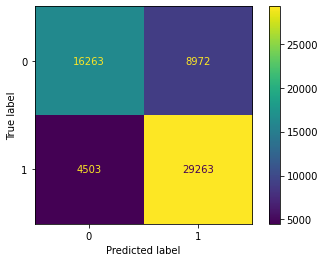

In [25]:
cm = confusion_matrix(y_test, logit_preds)
ConfusionMatrixDisplay(cm).plot()

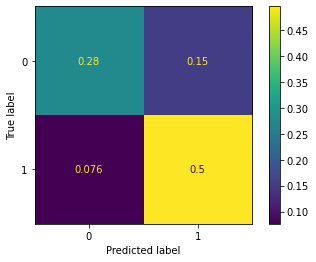

In [26]:
cm = confusion_matrix(y_test, logit_preds, normalize='all')
ConfusionMatrixDisplay(cm).plot()

## Optimized Logit

In [27]:
# optimize and save best logit model
logit = LogisticRegression(solver='liblinear', random_state=seed)

params = {
    'C': [1e-6, 100.0, 'log-uniform'],
}

search = BayesSearchCV(
    estimator=logit,
    search_spaces=params,
    n_jobs=-1,
    cv=kfold
)

In [28]:
search.fit(x_train, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LogisticRegression(random_state=18, solver='liblinear'),
              n_jobs=-1, search_spaces={'C': [1e-06, 100.0, 'log-uniform']})

In [29]:
search_train_preds = search.predict(x_train)

search_acc = accuracy_score(y_train, search_train_preds)
search_f1 = f1_score(y_train, search_train_preds)
search_roc = roc_auc_score(y_train, search_train_preds)
search_mcc = matthews_corrcoef(y_train, search_train_preds)

print(f"acc: {search_acc}")
print(f"f1: {search_f1}")
print(f"roc: {search_roc}")
print(f"mcc: {search_mcc}")

acc: 0.7097053028537531
f1: 0.7736632583954146
roc: 0.6804835870974766
mcc: 0.38118782489175107


In [30]:
search_preds = search.predict(x_test)

search_acc = accuracy_score(y_test, search_preds)
search_f1 = f1_score(y_test, search_preds)
search_roc = roc_auc_score(y_test, search_preds)
search_mcc = matthews_corrcoef(y_test, search_preds)

print(f"acc: {search_acc}")
print(f"f1: {search_f1}")
print(f"roc: {search_roc}")
print(f"mcc: {search_mcc}")

acc: 0.7717835290927273
f1: 0.8128431440683856
roc: 0.7558648027384028
mcc: 0.5297957990622271


In [31]:
search

BayesSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LogisticRegression(random_state=18, solver='liblinear'),
              n_jobs=-1, search_spaces={'C': [1e-06, 100.0, 'log-uniform']})

In [32]:
print(classification_report(y_test, search_preds))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71     25235
           1       0.77      0.87      0.81     33766

    accuracy                           0.77     59001
   macro avg       0.77      0.76      0.76     59001
weighted avg       0.77      0.77      0.77     59001



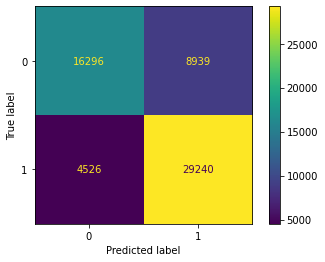

In [33]:
cm = confusion_matrix(y_test, search_preds)
ConfusionMatrixDisplay(cm).plot()

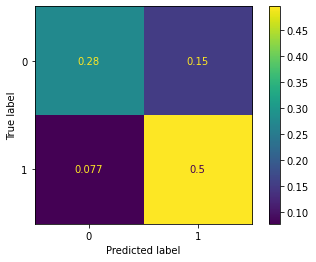

In [34]:
cm = confusion_matrix(y_test, search_preds, normalize='all')
ConfusionMatrixDisplay(cm).plot()

In [35]:
# save optimized model
pickle.dump(search, open('models/logit_predictor.sav', 'wb'))

## SVM

In [36]:
# svm = SVC(random_state=seed)
# svm_train, svm_val = train_funcs.train_and_measure(svm, kfold, 'svm - no tuning', x_train, y_train)

In [37]:
# svm_trainre

In [38]:
# svm_val

In [39]:
# svm.fit(x_train, y_train)
# svm_preds = svm.predict(x_test)

In [40]:
# svm_test = {
#     'svm - no tuning': {
#     'acc': accuracy_score(svm_preds, y_test),
#     'f1': f1_score(svm_preds, y_test),
#     'roc': roc_auc_score(svm_preds, y_test),
#     'mcc': matthews_corrcoef(svm_preds, y_test)
#     }
# }

In [41]:
# svm_test